In [45]:
from autogluon.tabular import TabularDataset, TabularPredictor
from ray import tune
import numpy as np
import math

In [73]:
#import data from Data/phil_socdata_train.csv, normalize (between 0 and 1) and standardize
train_data = TabularDataset('Data/phil_socdata_train.csv')

# drop the "T" column as it is not needed for training
train_data = train_data.drop(labels=['T'],axis=1)
train_data.head()


Loaded data from: Data/phil_socdata_train.csv | Columns = 7 / 7 | Rows = 615989 -> 615989


,Timestep,SOC,V,I,V_avg,I_avg
0,0,100.000031,400.125,-1.50,400.125,-1.50
1,1,100.000031,400.125,-1.56,400.125,-1.53
2,2,100.000031,400.125,-1.62,400.125,-1.56
3,3,100.000031,400.125,-1.68,400.125,-1.59
4,4,100.000031,400.125,-1.74,400.125,-1.62


In [74]:
label = 'SOC'
train_data[label].describe()

count    615989.000000
mean         46.872227
std          37.378184
min           0.000000
25%           0.844996
50%          50.980408
75%          82.352966
max         100.000031
Name: SOC, dtype: float64

In [97]:
minute = 60
time_limit = minute  # train various models for ~10 minutes

predictor = TabularPredictor(label=label).fit(
    train_data, 
    time_limit=time_limit, 
    presets='best_quality'
)



No path specified. Models will be saved in: "AutogluonModels/ag-20230405_045212/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 60s
AutoGluon will save models to "AutogluonModels/ag-20230405_045212/"
AutoGluon Version:  0.7.0
Python Version:     3.10.8
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #148-Ubuntu SMP Mon Oct 17 16:02:06 UTC 2022
Train Data Rows:    615989
Train Data Columns: 5
Label Column: SOC
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (100.000030517578, 0.0, 46.87223, 37.37818)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'r

In [98]:
# import test data from Data/phil_socdata_test.csv, normalize (between 0 and 1) and standardize
test_data1 = TabularDataset(f'Data/phil_socdata_test1.csv')
test_data2 = TabularDataset(f'Data/phil_socdata_test2.csv')

y_pred1= predictor.predict(test_data1.drop(columns=[label]))
y_pred1.head()

y_pred2= predictor.predict(test_data2.drop(columns=[label]))
y_pred2.head()

Loaded data from: Data/phil_socdata_test1.csv | Columns = 7 / 7 | Rows = 5617 -> 5617
Loaded data from: Data/phil_socdata_test2.csv | Columns = 7 / 7 | Rows = 18307 -> 18307


0    100.166473
1    100.024078
2    100.024078
3    100.024078
4    100.024078
Name: SOC, dtype: float32

In [99]:
predictor.evaluate(test_data1, silent=True)

/home/witvoetk/anaconda3/envs/tf/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(


{'root_mean_squared_error': -1.200160893595278,
 'mean_squared_error': -1.4403861705154164,
 'mean_absolute_error': -0.8176067478005581,
 'r2': 0.9921222600789745,
 'pearsonr': 0.9961195739360543,
 'median_absolute_error': -0.5954093924999988}

In [100]:
predictor.evaluate(test_data2, silent=True)

/home/witvoetk/anaconda3/envs/tf/lib/python3.10/site-packages/autogluon/tabular/predictor/predictor.py:1420: FutureWarning: Calling `predictor.predict_proba` when problem_type=regression will raise an AssertionError starting in AutoGluon v0.8. Please call `predictor.predict` instead.
  warnings.warn(


{'root_mean_squared_error': -2.8503046675975967,
 'mean_squared_error': -8.124236698128646,
 'mean_absolute_error': -2.238877817774125,
 'r2': 0.9874357400556525,
 'pearsonr': 0.9957151882594246,
 'median_absolute_error': -1.9722595191113292}

In [101]:
predictor.leaderboard(test_data1, silent=True)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBMXT_BAG_L2,-1.200161,-1.239897,1.310946,67.853015,44.094621,0.365399,18.565052,14.061228,2,True,3
1,WeightedEnsemble_L3,-1.200161,-1.239897,1.312340,67.859581,44.104844,0.001395,0.006567,0.010223,3,True,4
2,LightGBMXT_BAG_L1,-1.230244,-1.262322,0.945547,49.287963,30.033393,0.945547,49.287963,30.033393,1,True,1
3,WeightedEnsemble_L2,-1.230244,-1.262322,0.947206,49.293125,30.040489,0.001659,0.005162,0.007096,2,True,2


In [102]:
predictor.leaderboard(test_data2, silent=True)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBMXT_BAG_L2,-2.850305,-1.239897,2.299976,67.853015,44.094621,0.706421,18.565052,14.061228,2,True,3
1,WeightedEnsemble_L3,-2.850305,-1.239897,2.301996,67.859581,44.104844,0.002020,0.006567,0.010223,3,True,4
2,LightGBMXT_BAG_L1,-3.202380,-1.262322,1.593555,49.287963,30.033393,1.593555,49.287963,30.033393,1,True,1
3,WeightedEnsemble_L2,-3.202380,-1.262322,1.595240,49.293125,30.040489,0.001685,0.005162,0.007096,2,True,2


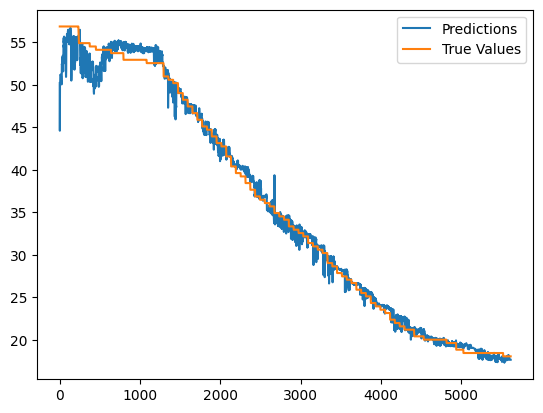

In [103]:
#plots the predicted vs actual values of the top performing model using matplotlib
import matplotlib.pyplot as plt
plt.plot(y_pred1, label="Predictions")
plt.plot(test_data1[label], label="True Values")
plt.legend()
plt.show()

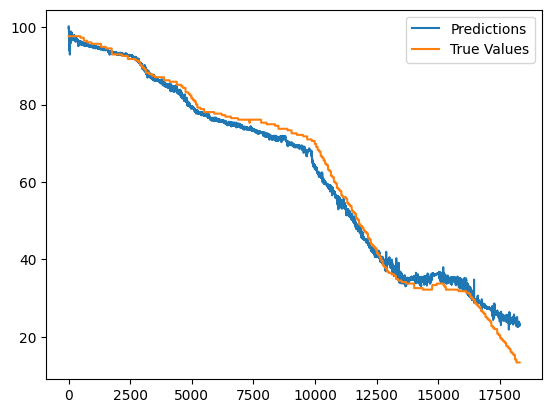

In [104]:
plt.plot(y_pred2, label="Predictions")
plt.plot(test_data2[label], label="True Values")
plt.legend()
plt.show()

In [105]:
mse_test = np.mean(((y_pred1 - test_data1[label])**2))
rmse_test = math.sqrt(mse_test)
print("Test data 1 RMSE", rmse_test)
mse_test = np.mean(((y_pred2 - test_data2[label])**2))
rmse_test = math.sqrt(mse_test)
print("Test data 2 RMSE", rmse_test)

Test data 1 RMSE 1.200160893595278
Test data 2 RMSE 2.8503046675975967


In [106]:
predictor.feature_importance(test_data1)

These features in provided data are not utilized by the predictor and will be ignored: ['T']
Computing feature importance via permutation shuffling for 5 features using 5000 rows with 5 shuffle sets...
	32.45s	= Expected runtime (6.49s per shuffle set)
	20.47s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
V_avg,9.295749,0.186453,1.941289e-08,5,9.679659,8.911840
Timestep,6.839916,0.168528,4.418934e-08,5,7.186918,6.492914
V,2.544507,0.075922,9.500008e-08,5,2.700832,2.388183
I,0.685095,0.025504,2.300595e-07,5,0.737609,0.632581
I_avg,0.174707,0.018903,1.619322e-05,5,0.213629,0.135785


In [107]:
predictor.feature_importance(test_data2)

These features in provided data are not utilized by the predictor and will be ignored: ['T']
Computing feature importance via permutation shuffling for 5 features using 5000 rows with 5 shuffle sets...
	30.78s	= Expected runtime (6.16s per shuffle set)
	19.45s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
V,11.964860,0.105134,7.152871e-10,5,12.181332,11.748387
Timestep,9.644161,0.224268,3.506561e-08,5,10.105932,9.182389
V_avg,9.272039,0.065492,2.986867e-10,5,9.406889,9.137190
I_avg,1.692217,0.034909,2.172068e-08,5,1.764096,1.620339
I,0.598595,0.024694,3.467629e-07,5,0.649440,0.547749
